
Ce Notebook contient l'ensemble des codes traitant de la modélisation par deeplearning (cf Rapport projet) :
- Méthode de plongement lexicaux : Word2Vec
- Méthode de plongement de document : Doc2Vec
- Réseau de neurones convolutionnels pour l'analyse de sentiment 

In [1]:
# -*- coding: utf-8 -*-
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline 
import seaborn as sns
import re

In [2]:
import os
import sys
import gensim

In [ ]:
from google.colab import files

uploaded = files.upload()

Saving reviews_trust.csv to reviews_trust.csv


In [ ]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [ ]:
df = pd.read_csv("reviews_trust.csv")
df = df[["Commentaire", "star"]]
df["Sentiment"] = df["star"].apply(lambda x : np.where(x >=4 , 1 , 0))  # ajout de la colonne Sentiment à df
df["Sentiment"].value_counts(normalize = True) # léger déséquilibre des classes mais peut être traité comme un problème non déséquilibré

#Suppression des valeurs manquantes de la colonne Commentaire
df = df.dropna(axis = 0, how = 'any', subset =["Commentaire"])
df.reset_index(inplace = True)
df = df.drop(['index','star'],axis = 1)

#Nettoyages des commentaires et étapes de normalisation 

def find_exclamation(com):   #compte le nombre de points d'exclamation d'un commentaire
    r = re.compile(r"\!")
    exclamation = r.findall(com)
    return len(exclamation)

def find_interogation(com): #compte le nombre de points d'interogation d'un commentaire
    r = re.compile(r"\?")
    interogation = r.findall(com)
    return len(interogation)

def findCAPSLOCK(com):  #compte le nombre de caractères en majuscule d'un commentaire
    r = re.compile(r"[A-Z]")
    capslock = r.findall(com)
    return len(capslock)

def find_etc(com): #compte le nombre de chaine de ".." d'un commentaire
    r = re.compile(r"\.{2,}")
    etc = r.findall(com)
    return len(etc)

df["CAPSLOCK"]= df["Commentaire"].apply(lambda x : findCAPSLOCK(x))
df["exclamation"]= df["Commentaire"].apply(lambda x : find_exclamation(x))
df["interogation"]= df["Commentaire"].apply(lambda x : find_interogation(x))
df["chainpoints"]= df["Commentaire"].apply(lambda x : find_etc(x))
df['nb_caracter'] = df["Commentaire"].apply(len)
#Tokenization via RegexpTokenizer

from nltk.tokenize.regexp import RegexpTokenizer
tokenizer = RegexpTokenizer("[a-zA-Zéèê]{3,}")
df["preprocessed"] = df["Commentaire"].apply(lambda x : " ".join(x.lower() for x in str(x).strip().split()))

# On remplace les éèê par e
def remplacement_carac_e(com):
    text=re.sub(r"[éèêë]","e",com)
    return text
df["preprocessed"] = df["preprocessed"].apply(lambda x : remplacement_carac_e(x))

def neg_identify(text): 
    text = tokenizer.tokenize(text)
    for pos, word in enumerate(text) :
        if pos != len(text)-1 :
            if (word == 'ne' or word == "n" or word =="n'"):
                text[pos+1] = "NON_"+text[pos+1]
    text = " ".join(text)
    return (text)
df["preprocessed"] = df["preprocessed"].apply(lambda x : neg_identify(x))

# Déclaration des stopwords
from nltk.corpus import stopwords
stop_words = set(stopwords.words('french'))
stop_words.update (["?","!",".","_",":",",",";","-","--","...","'","...","'",',',',','…la','la','le','les','..','…','(',')','a+','+','etc…','qq','``',"j'","j '"])
# après une première visualisation des données, "commande" est très freqement apparu dans les 2 catégories et n'apporte à priori pas d'information sur la satisfaction du client"
# print(stop_words)

# Definition d'une fonction de filtrage de stopwords
def stopwords_filtering(chaine): # fonction renvoyant une liste ne contenant pas les stopwords
    tokens =[]
    chaine = tokenizer.tokenize(chaine)
    for mot in chaine :
        if mot not in stop_words :#conservation des mots non stopwords 
            tokens.append(mot)
    tokens = " ".join(tokens)
    return tokens
df["preprocessed"] = df["preprocessed"].apply(lambda x : stopwords_filtering(x))

# Opération de stemming

from nltk.stem.snowball import FrenchStemmer

stemmer = FrenchStemmer()
def  stemming(text) :
    text = tokenizer.tokenize(text)
    stemmed_text = ""
    for mot in text: 
        stem = stemmer.stem(mot)
        stemmed_text =  stemmed_text +" "+ stem
    return  stemmed_text

df["preprocessed"] = df["preprocessed"].apply(lambda x: stemming(x))


In [ ]:
%%time
from sklearn.model_selection import train_test_split 

X = df.drop(['Commentaire', 'Sentiment'], axis=1)
y = df["Sentiment"]



CPU times: user 5.74 ms, sys: 0 ns, total: 5.74 ms
Wall time: 6 ms


# Analyse de sentiment W2V

In [ ]:
%%time

tokenized_comment = X['preprocessed'].apply(lambda x: x.split()) # tokenizing 

model_w2v = gensim.models.Word2Vec(
            tokenized_comment,
            size=200, # nombre de variables indépendantes souhaité
            window=5, # nombre de fenêtres 
            min_count=2, # Ignorer les mots dont la fréquence totale est inférieure à 2                                 
            sg = 1, # 1 pour skip-Gram
            hs = 0,
            negative = 10, # nombre d'échantillons considérés comme négatifs
            workers= -1, # nombre de coeurs 
            seed = 34 #graine aléatoire pour la répétabilité
) 

model_w2v.train(tokenized_comment, total_examples = len(X['preprocessed']), epochs=20)


training_loss = model_w2v.get_latest_training_loss()
print(training_loss)

0
CPU times: user 2.03 s, sys: 53.1 ms, total: 2.08 s
Wall time: 2.07 s


In [ ]:

def word_vector(tokens, size):
    vec = np.zeros(size).reshape((1, size))
    count = 0
    for word in tokens:
        try:
            vec += model_w2v.wv[word].reshape((1, size))
            count += 1.
        except KeyError:  # prend en charge les cas ou le token n'est pas dans vocabulary
            continue
    if count != 0:
        vec /= count
    return vec

In [ ]:

train_tokenized_comment = X['preprocessed'].apply(lambda x: x.split()) # tokenisation

#préparation du word2vec feature

wordvec_arrays = np.zeros((len(tokenized_comment), 200)) 
for i in range(len(tokenized_comment)):
    wordvec_arrays[i,:] = word_vector(tokenized_comment[i], 200)
wordvec_df = pd.DataFrame(wordvec_arrays)
wordvec_df.shape

(19834, 200)

In [ ]:
from sklearn.model_selection import train_test_split 
from sklearn.preprocessing import MinMaxScaler
X = df.drop(['Commentaire', 'Sentiment','preprocessed'], axis=1)
mms = MinMaxScaler()
X = pd.concat([wordvec_df, X], axis=1)
X = pd.DataFrame(mms.fit_transform(X), columns= X.columns)
y = df["Sentiment"]
X_train, X_test, y_train, y_test = train_test_split(X,y, train_size = 0.8, random_state = 0)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,


In [ ]:
from sklearn.preprocessing import scale
import numpy as np
from keras.models import Sequential
from keras.layers import Dense

In [ ]:
# Définition du réseau de neuronnes
model_word2vec = Sequential()
model_word2vec.add(Dense(256, activation='relu', input_dim=205))
model_word2vec.add(Dense(256, activation='relu'))
model_word2vec.add(Dense(256, activation='relu'))
model_word2vec.add(Dense(1, activation='sigmoid'))
model_word2vec.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model_word2vec.summary()




Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_20 (Dense)            (None, 256)               52736     
                                                                 
 dense_21 (Dense)            (None, 256)               65792     
                                                                 
 dense_22 (Dense)            (None, 256)               65792     
                                                                 
 dense_23 (Dense)            (None, 1)                 257       
                                                                 
Total params: 184,577
Trainable params: 184,577
Non-trainable params: 0
_________________________________________________________________


In [ ]:
import time
start = time.time()
model_history = model_word2vec.fit( X_train,y_train, validation_split= 0.1, epochs=100, batch_size=32, verbose=1)
end = time.time()

Epoch 1/100
447/447 [==============================] - 3s 5ms/step - loss: 0.4523 - accuracy: 0.7786 - val_loss: 0.4126 - val_accuracy: 0.8198
Epoch 2/100
447/447 [==============================] - 2s 4ms/step - loss: 0.3956 - accuracy: 0.8155 - val_loss: 0.3664 - val_accuracy: 0.8229
Epoch 3/100
447/447 [==============================] - 2s 4ms/step - loss: 0.3699 - accuracy: 0.8312 - val_loss: 0.3813 - val_accuracy: 0.8135
Epoch 4/100
447/447 [==============================] - 2s 4ms/step - loss: 0.3655 - accuracy: 0.8319 - val_loss: 0.3852 - val_accuracy: 0.8286
Epoch 5/100
447/447 [==============================] - 2s 4ms/step - loss: 0.3524 - accuracy: 0.8407 - val_loss: 0.3382 - val_accuracy: 0.8557
Epoch 6/100
447/447 [==============================] - 2s 4ms/step - loss: 0.3532 - accuracy: 0.8391 - val_loss: 0.3889 - val_accuracy: 0.8154
Epoch 7/100
447/447 [==============================] - 2s 4ms/step - loss: 0.3589 - accuracy: 0.8343 - val_loss: 0.3881 - val_accuracy: 0.8318

In [ ]:
print("Durée d'entrainement est de :", end-start, "secondes")

Durée d'entrainement est de : 262.5864222049713 secondes


In [ ]:
y_word2vec_pred = model_word2vec.predict(X_test)

y_w2v_classe = []
for i in range(len(y_word2vec_pred)): 
 
  if y_word2vec_pred[i,0] > 0.5: 
    y_w2v_classe.append(1)
  else:
    y_w2v_classe.append(0)


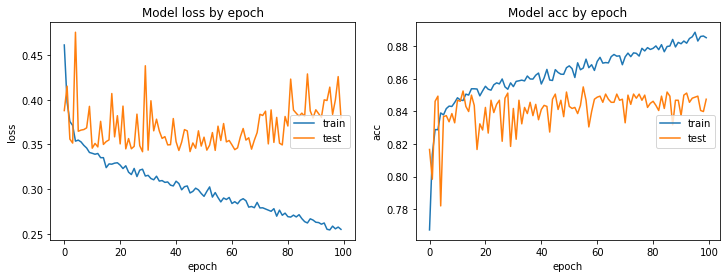

In [ ]:
plt.figure(figsize=(12,4))

plt.subplot(121)
plt.plot(model_history.history['loss'])
plt.plot(model_history.history['val_loss'])
plt.title('Model loss by epoch')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='right')

plt.subplot(122)
plt.plot(model_history.history['accuracy'])
plt.plot(model_history.history['val_accuracy'])
plt.title('Model acc by epoch')
plt.ylabel('acc')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='right')
plt.show()

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_w2v_classe))

              precision    recall  f1-score   support

           0       0.84      0.83      0.83      1652
           1       0.88      0.89      0.88      2315

    accuracy                           0.86      3967
   macro avg       0.86      0.86      0.86      3967
weighted avg       0.86      0.86      0.86      3967



# Deeplearning doc2vec DM

In [ ]:
tokenized_comment = X['preprocessed'].apply(lambda x: x.split()) # tokenisation 

In [ ]:
from gensim.models.doc2vec import TaggedDocument

def labelized_comment(comments):  # labeliser chaque commentaire  du dataframe
    labelized = []
    for i, s in zip(comments.index, comments):
        labelized.append(TaggedDocument(s, ["comment_" + str(i)]))
    return labelized

labeled_com = labelized_comment(tokenized_comment)


In [ ]:
%%time

model_d2v = gensim.models.Doc2Vec(dm=1, # dm = 1 distributed memory model
                                  dm_mean=1, # dm_mean = 1 pour l'utilisation de la moyenne des vecteurs de mots
                                  vector_size=200, # nombre de features souhaité
                                  window=5, # taille de la fenêtre                                
                                  negative=7, # nombre d'échantillons considérés comme négatifs
                                  min_count=2,  # Ignorer les mots dont la fréquence totale est inférieure à 2                                      
                                  workers=-1, # nombre de coeurs                                 
                                  alpha=0.1, # vitesse d'apprentissage                                
                                  seed = 23 # graine aléatoire pour la répétabilité
                                 ) 

model_d2v.build_vocab(labeled_com)

model_d2v.train(labeled_com, total_examples= len(X["preprocessed"]), epochs=20)

CPU times: user 5.59 s, sys: 66.6 ms, total: 5.65 s
Wall time: 5.66 s


In [ ]:
# DOc2vec Feature Set

docvec_arrays = np.zeros((len(tokenized_comment), 200)) 
for i in range(len(X)):
    docvec_arrays[i,:] = model_d2v.docvecs[i].reshape((1,200))    

docvec_df = pd.DataFrame(docvec_arrays) 
docvec_df.shape

(19834, 200)

In [ ]:
from sklearn.model_selection import train_test_split 
from sklearn.preprocessing import MinMaxScaler
X = df.drop(['Commentaire', 'Sentiment','preprocessed'], axis=1)
mms = MinMaxScaler()
X = pd.concat([docvec_df, X], axis=1)
X = pd.DataFrame(mms.fit_transform(X), columns= X.columns)
y = df["Sentiment"]
X_train, X_test, y_train, y_test = train_test_split(X,y, train_size = 0.8, random_state = 0)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,


In [ ]:
from sklearn.preprocessing import scale
import numpy as np
from keras.models import Sequential
from keras.layers import Dense

In [ ]:
model_d2v_dm = Sequential()
model_d2v_dm.add(Dense(256, activation='relu', input_dim=205))
model_d2v_dm.add(Dense(256, activation='relu'))
model_d2v_dm.add(Dense(256, activation='relu'))
model_d2v_dm.add(Dense(1, activation='sigmoid'))
model_d2v_dm.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model_d2v_dm.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_8 (Dense)             (None, 256)               52736     
                                                                 
 dense_9 (Dense)             (None, 256)               65792     
                                                                 
 dense_10 (Dense)            (None, 256)               65792     
                                                                 
 dense_11 (Dense)            (None, 1)                 257       
                                                                 
Total params: 184,577
Trainable params: 184,577
Non-trainable params: 0
_________________________________________________________________


In [ ]:
import time
start = time.time()
model_history = model_d2v_dm.fit( X_train,y_train, validation_split= 0.1, epochs=400, batch_size=32, verbose=1)
end = time.time()

Epoch 1/400
447/447 [==============================] - 5s 8ms/step - loss: 0.6787 - accuracy: 0.5884 - val_loss: 0.6771 - val_accuracy: 0.5772
Epoch 2/400
447/447 [==============================] - 3s 7ms/step - loss: 0.6242 - accuracy: 0.6583 - val_loss: 0.6421 - val_accuracy: 0.6503
Epoch 3/400
447/447 [==============================] - 3s 7ms/step - loss: 0.5452 - accuracy: 0.7341 - val_loss: 0.5071 - val_accuracy: 0.7763
Epoch 4/400
447/447 [==============================] - 2s 5ms/step - loss: 0.4848 - accuracy: 0.7818 - val_loss: 0.5046 - val_accuracy: 0.7643
Epoch 5/400
447/447 [==============================] - 2s 4ms/step - loss: 0.4653 - accuracy: 0.7952 - val_loss: 0.4865 - val_accuracy: 0.7769
Epoch 6/400
447/447 [==============================] - 2s 3ms/step - loss: 0.4565 - accuracy: 0.7988 - val_loss: 0.4671 - val_accuracy: 0.8015
Epoch 7/400
447/447 [==============================] - 2s 3ms/step - loss: 0.4560 - accuracy: 0.8010 - val_loss: 0.4715 - val_accuracy: 0.7895

In [ ]:
print("La durée d'entraînement est de :", end-start, "secondes")

La durée d'entraînement est de : 738.4790959358215 secondes


In [ ]:
y_d2v_pred = model_d2v_dm.predict(X_test)

y_d2v_dm_classe = []
for i in range(len(y_d2v_pred)): 
 
  if y_d2v_pred[i,0] > 0.5: 
    y_d2v_dm_classe.append(1)
  else:
    y_d2v_dm_classe.append(0)


<Figure size 864x288 with 0 Axes>

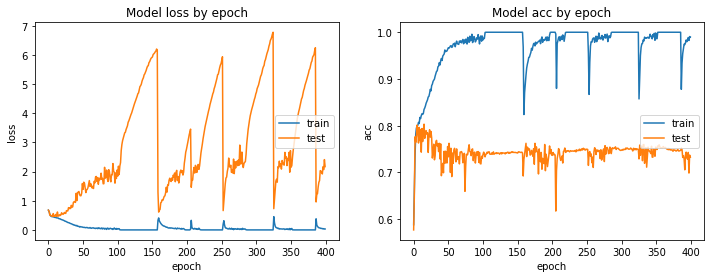

In [ ]:
plt.figure(figsize=(12,4))

plt.figure(figsize=(12,4))

plt.subplot(121)
plt.plot(model_history.history['loss'])
plt.plot(model_history.history['val_loss'])
plt.title('Model loss by epoch')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='right')

plt.subplot(122)
plt.plot(model_history.history['accuracy'])
plt.plot(model_history.history['val_accuracy'])
plt.title('Model acc by epoch')
plt.ylabel('acc')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='right')
plt.show()

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_d2v_dm_classe))

              precision    recall  f1-score   support

           0       0.69      0.66      0.68      1652
           1       0.77      0.78      0.77      2315

    accuracy                           0.73      3967
   macro avg       0.73      0.72      0.72      3967
weighted avg       0.73      0.73      0.73      3967



#Deeplearning doc2vec DBOW


In [ ]:
from gensim.models.doc2vec import TaggedDocument

def labelized_comment(comments):  # labeliser chaque commentaire  du dataframe
    labelized = []
    for i, s in zip(comments.index, comments):
        labelized.append(TaggedDocument(s, ["comment_" + str(i)]))
    return labelized

labeled_com = labelized_comment(tokenized_comment)


In [ ]:
%%time

model_d2v_dbow = gensim.models.Doc2Vec(dm=0, # dm = 0 pour dbow
                                  vector_size=200, # nombre de features souhaités
                                  window=5, # taille de la fenêtre                                 
                                  negative=7, # nombre d'échantillons considérés comme négatifs
                                  min_count=2, # Ignorer les mots dont la fréquence totale est inférieure à 2                                  
                                  workers=-1, # nombre de coeurs                             
                                  alpha=0.1, # vitesse d'apprentissage                                  
                                  seed = 23 # graine aléatoire pour la répétabilité
                                 ) 

model_d2v_dbow.build_vocab(labeled_com)

model_d2v_dbow.train(labeled_com, total_examples= len(X["preprocessed"]), epochs=20)

CPU times: user 5.67 s, sys: 73.3 ms, total: 5.74 s
Wall time: 5.73 s


In [ ]:
# Doc2vec Feature Set

docvec_arrays = np.zeros((len(tokenized_comment), 200)) 
for i in range(len(X)):
    docvec_arrays[i,:] = model_d2v.docvecs[i].reshape((1,200))    

docvec_df = pd.DataFrame(docvec_arrays) 
docvec_df.shape

(19834, 200)

In [ ]:
from sklearn.model_selection import train_test_split 
from sklearn.preprocessing import MinMaxScaler
X = df.drop(['Commentaire', 'Sentiment','preprocessed'], axis=1)
mms = MinMaxScaler()
X = pd.concat([docvec_df, X], axis=1)
X = pd.DataFrame(mms.fit_transform(X), columns= X.columns)
y = df["Sentiment"]
X_train, X_test, y_train, y_test = train_test_split(X,y, train_size = 0.8, random_state = 0)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,


In [ ]:
from sklearn.preprocessing import scale
import numpy as np
from keras.models import Sequential
from keras.layers import Dense

In [ ]:
model_d2v_dbow = Sequential()
model_d2v_dbow.add(Dense(256, activation='relu', input_dim=205))
model_d2v_dbow.add(Dense(256, activation='relu'))
model_d2v_dbow.add(Dense(256, activation='relu'))
model_d2v_dbow.add(Dense(1, activation='sigmoid'))
model_d2v_dbow.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model_d2v_dbow.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_12 (Dense)            (None, 256)               52736     
                                                                 
 dense_13 (Dense)            (None, 256)               65792     
                                                                 
 dense_14 (Dense)            (None, 256)               65792     
                                                                 
 dense_15 (Dense)            (None, 1)                 257       
                                                                 
Total params: 184,577
Trainable params: 184,577
Non-trainable params: 0
_________________________________________________________________


In [ ]:
import time 
start = time.time()
model_history = model_d2v_dbow.fit( X_train,y_train, validation_split= 0.1, epochs=400, batch_size=32, verbose=1)
end = time.time()

Epoch 1/400
447/447 [==============================] - 2s 4ms/step - loss: 0.6778 - accuracy: 0.5865 - val_loss: 0.6857 - val_accuracy: 0.5488
Epoch 2/400
447/447 [==============================] - 2s 3ms/step - loss: 0.6052 - accuracy: 0.6753 - val_loss: 0.5787 - val_accuracy: 0.7076
Epoch 3/400
447/447 [==============================] - 2s 3ms/step - loss: 0.5212 - accuracy: 0.7506 - val_loss: 0.4933 - val_accuracy: 0.7908
Epoch 4/400
447/447 [==============================] - 2s 4ms/step - loss: 0.4815 - accuracy: 0.7861 - val_loss: 0.5265 - val_accuracy: 0.7524
Epoch 5/400
447/447 [==============================] - 2s 4ms/step - loss: 0.4716 - accuracy: 0.7906 - val_loss: 0.5506 - val_accuracy: 0.7391
Epoch 6/400
447/447 [==============================] - 2s 4ms/step - loss: 0.4557 - accuracy: 0.8025 - val_loss: 0.4723 - val_accuracy: 0.7864
Epoch 7/400
447/447 [==============================] - 2s 4ms/step - loss: 0.4529 - accuracy: 0.8069 - val_loss: 0.5155 - val_accuracy: 0.7776

In [ ]:
print("La durée d'entraînement est de :", end-start, "secondes")

La durée d'entraînement est de : 742.5513386726379 secondes


In [ ]:
y_d2v_pred = model_d2v_dbow.predict(X_test)

y_d2v_dbow_classe = []
for i in range(len(y_d2v_pred)): 
 
  if y_d2v_pred[i,0] > 0.5: 
    y_d2v_dbow_classe.append(1)
  else:
    y_d2v_dbow_classe.append(0)



<Figure size 864x288 with 0 Axes>

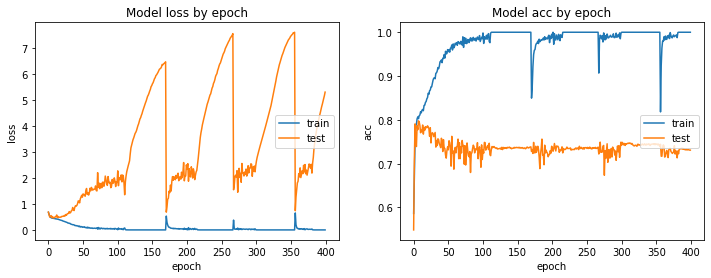

In [ ]:
plt.figure(figsize=(12,4))

plt.figure(figsize=(12,4))

plt.subplot(121)
plt.plot(model_history.history['loss'])
plt.plot(model_history.history['val_loss'])
plt.title('Model loss by epoch')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='right')

plt.subplot(122)
plt.plot(model_history.history['accuracy'])
plt.plot(model_history.history['val_accuracy'])
plt.title('Model acc by epoch')
plt.ylabel('acc')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='right')
plt.show()

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_d2v_dbow_classe))

              precision    recall  f1-score   support

           0       0.69      0.67      0.68      1652
           1       0.77      0.79      0.78      2315

    accuracy                           0.74      3967
   macro avg       0.73      0.73      0.73      3967
weighted avg       0.74      0.74      0.74      3967



# Deeplearning model CNN +

In [ ]:
X = df.drop(['Commentaire', 'Sentiment'], axis=1)
y = df["Sentiment"]


In [ ]:
from sklearn.model_selection import train_test_split

SEED = 200

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=SEED)

In [ ]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

tokenizer = Tokenizer(num_words=100000)
tokenizer.fit_on_texts(X_train['preprocessed'])
sequences_train = tokenizer.texts_to_sequences(X_train['preprocessed'])


# vérification de la longueur maximale d'un commentaire pour le padding
length = []
for x in X_train['preprocessed']:
    length.append(len(x.split()))
max(length)

500

In [ ]:
X_train_seq = pad_sequences(sequences_train, maxlen=500)
X_train_seq

array([[  0,   0,   0, ...,  68,  75,  69],
       [  0,   0,   0, ...,  68, 893, 125],
       [  0,   0,   0, ...,  10,   6, 355],
       ...,
       [  0,   0,   0, ..., 250,  16,   1],
       [  0,   0,   0, ..., 181, 161,  19],
       [  0,   0,   0, ...,  31,  36, 244]], dtype=int32)

In [ ]:
# création des séquences 
sequences_test = tokenizer.texts_to_sequences(X_test['preprocessed'])
X_test_seq = pad_sequences(sequences_test, maxlen=500)

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Conv1D, GlobalMaxPooling1D
from keras.layers.embeddings import Embedding

model_cnn = Sequential()

e = Embedding(100000, 200, input_length=500)
model_cnn.add(e)
model_cnn.add(Conv1D(filters=200, kernel_size=2, padding='valid', activation='relu', strides=1))
model_cnn.add(GlobalMaxPooling1D())
model_cnn.add(Dense(256, activation='relu'))
model_cnn.add(Dense(1, activation='sigmoid'))
model_cnn.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

model_cnn.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 500, 200)          20000000  
                                                                 
 conv1d_1 (Conv1D)           (None, 499, 200)          80200     
                                                                 
 global_max_pooling1d_1 (Glo  (None, 200)              0         
 balMaxPooling1D)                                                
                                                                 
 dense_18 (Dense)            (None, 256)               51456     
                                                                 
 dense_19 (Dense)            (None, 1)                 257       
                                                                 
Total params: 20,131,913
Trainable params: 20,131,913
Non-trainable params: 0
__________________________________________

In [ ]:
import time 

start = time.time()

cnn_history = model_cnn.fit(X_train_seq, y_train, validation_data=(X_test_seq, y_test), epochs=25, batch_size=32, verbose=1, validation_split= 0.2)
score,acc = model_cnn.evaluate(X_test_seq, y_test, verbose = 1, batch_size = 32)
print("score: %.2f" % (score))
print("acc: %.2f" % (acc))

end = time.time()

Epoch 1/25
397/397 [==============================] - 197s 495ms/step - loss: 0.3010 - accuracy: 0.8636 - val_loss: 0.2643 - val_accuracy: 0.8888
Epoch 2/25
397/397 [==============================] - 161s 405ms/step - loss: 0.1773 - accuracy: 0.9294 - val_loss: 0.2748 - val_accuracy: 0.8875
Epoch 3/25
397/397 [==============================] - 159s 402ms/step - loss: 0.1101 - accuracy: 0.9597 - val_loss: 0.3302 - val_accuracy: 0.8828
Epoch 4/25
397/397 [==============================] - 158s 397ms/step - loss: 0.0650 - accuracy: 0.9786 - val_loss: 0.3813 - val_accuracy: 0.8825
Epoch 5/25
397/397 [==============================] - 158s 398ms/step - loss: 0.0432 - accuracy: 0.9851 - val_loss: 0.4782 - val_accuracy: 0.8800
Epoch 6/25
397/397 [==============================] - 156s 394ms/step - loss: 0.0374 - accuracy: 0.9861 - val_loss: 0.5291 - val_accuracy: 0.8784
Epoch 7/25
397/397 [==============================] - 160s 402ms/step - loss: 0.0276 - accuracy: 0.9903 - val_loss: 0.5534 -

In [ ]:
from joblib import dump, load
dump(model_cnn, 'CNN_analyse_sentiment.joblib') 

INFO:tensorflow:Assets written to: ram://b92d689f-35b0-4c4a-93a1-643cde3585b2/assets


['CNN_analyse_sentiment.joblib']

In [ ]:

from tensorflow.keras.models import save_model, load_model
# save model
model_cnn.save('cnn_sentiment_analysis.h5')
print('Model Saved!')



Model Saved!


<Figure size 864x288 with 0 Axes>

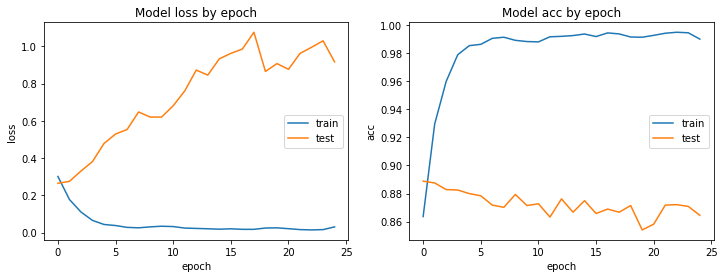

In [ ]:
plt.figure(figsize=(12,4))

plt.figure(figsize=(12,4))

plt.subplot(121)
plt.plot(cnn_history.history['loss'])
plt.plot(cnn_history.history['val_loss'])
plt.title('Model loss by epoch')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='right')

plt.subplot(122)
plt.plot(cnn_history.history['accuracy'])
plt.plot(cnn_history.history['val_accuracy'])
plt.title('Model acc by epoch')
plt.ylabel('acc')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='right')
plt.show()

In [ ]:
cnn_pred = model_cnn.predict(X_test_seq)

In [ ]:
cnn_classe = []
for i in range(len(cnn_pred)): 
 
  if cnn_pred[i,0] > 0.5: 
    cnn_classe.append(1)
  else:
    cnn_classe.append(0)

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_test, cnn_classe))

# Deeplearning model CNN

In [ ]:
X = df.drop(['Commentaire', 'Sentiment'], axis=1)
y = df["Sentiment"]


In [ ]:
from sklearn.model_selection import train_test_split

SEED = 200

from sklearn.preprocessing import MinMaxScaler
X = df.drop(['Commentaire', 'Sentiment','preprocessed'], axis=1)
mms = MinMaxScaler()
X = pd.concat([docvec_df, X], axis=1)
X = pd.DataFrame(mms.fit_transform(X), columns= X.columns)
y = df["Sentiment"]
X_train, X_test, y_train, y_test = train_test_split(X,y, train_size = 0.8, random_state = 0)


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=SEED)

In [ ]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

tokenizer = Tokenizer(num_words=100000)
tokenizer.fit_on_texts(X_train['preprocessed'])
sequences_train = tokenizer.texts_to_sequences(X_train['preprocessed'])


# vérification de la longueur maximale d'un commentaire pour le padding
length = []
for x in X_train['preprocessed']:
    length.append(len(x.split()))
max(length)

500

In [ ]:
X_train_seq = pad_sequences(sequences_train, maxlen=500)
X_train_seq

array([[  0,   0,   0, ...,  68,  75,  69],
       [  0,   0,   0, ...,  68, 893, 125],
       [  0,   0,   0, ...,  10,   6, 355],
       ...,
       [  0,   0,   0, ..., 250,  16,   1],
       [  0,   0,   0, ..., 181, 161,  19],
       [  0,   0,   0, ...,  31,  36, 244]], dtype=int32)

In [ ]:
# création des séquences 
sequences_test = tokenizer.texts_to_sequences(X_test['preprocessed'])
X_test_seq = pad_sequences(sequences_test, maxlen=500)

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Conv1D, GlobalMaxPooling1D
from keras.layers.embeddings import Embedding

model_cnn = Sequential()

e = Embedding(100000, 200, input_length=500)
model_cnn.add(e)
model_cnn.add(Conv1D(filters=200, kernel_size=2, padding='valid', activation='relu', strides=1))
model_cnn.add(GlobalMaxPooling1D())
model_cnn.add(Dense(256, activation='relu'))
model_cnn.add(Dense(1, activation='sigmoid'))
model_cnn.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

model_cnn.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 500, 200)          20000000  
                                                                 
 conv1d_1 (Conv1D)           (None, 499, 200)          80200     
                                                                 
 global_max_pooling1d_1 (Glo  (None, 200)              0         
 balMaxPooling1D)                                                
                                                                 
 dense_18 (Dense)            (None, 256)               51456     
                                                                 
 dense_19 (Dense)            (None, 1)                 257       
                                                                 
Total params: 20,131,913
Trainable params: 20,131,913
Non-trainable params: 0
__________________________________________

In [ ]:
import time 

start = time.time()

cnn_history = model_cnn.fit(X_train_seq, y_train, validation_data=(X_test_seq, y_test), epochs=25, batch_size=32, verbose=1, validation_split= 0.2)
score,acc = model_cnn.evaluate(X_test_seq, y_test, verbose = 1, batch_size = 32)
print("score: %.2f" % (score))
print("acc: %.2f" % (acc))

end = time.time()

Epoch 1/25
397/397 [==============================] - 197s 495ms/step - loss: 0.3010 - accuracy: 0.8636 - val_loss: 0.2643 - val_accuracy: 0.8888
Epoch 2/25
397/397 [==============================] - 161s 405ms/step - loss: 0.1773 - accuracy: 0.9294 - val_loss: 0.2748 - val_accuracy: 0.8875
Epoch 3/25
397/397 [==============================] - 159s 402ms/step - loss: 0.1101 - accuracy: 0.9597 - val_loss: 0.3302 - val_accuracy: 0.8828
Epoch 4/25
397/397 [==============================] - 158s 397ms/step - loss: 0.0650 - accuracy: 0.9786 - val_loss: 0.3813 - val_accuracy: 0.8825
Epoch 5/25
397/397 [==============================] - 158s 398ms/step - loss: 0.0432 - accuracy: 0.9851 - val_loss: 0.4782 - val_accuracy: 0.8800
Epoch 6/25
397/397 [==============================] - 156s 394ms/step - loss: 0.0374 - accuracy: 0.9861 - val_loss: 0.5291 - val_accuracy: 0.8784
Epoch 7/25
397/397 [==============================] - 160s 402ms/step - loss: 0.0276 - accuracy: 0.9903 - val_loss: 0.5534 -

In [ ]:
from joblib import dump, load
dump(model_cnn, 'CNN_analyse_sentiment.joblib') 

INFO:tensorflow:Assets written to: ram://b92d689f-35b0-4c4a-93a1-643cde3585b2/assets


['CNN_analyse_sentiment.joblib']

In [ ]:

from tensorflow.keras.models import save_model, load_model
# save model
model_cnn.save('cnn_sentiment_analysis.h5')
print('Model Saved!')



Model Saved!


<Figure size 864x288 with 0 Axes>

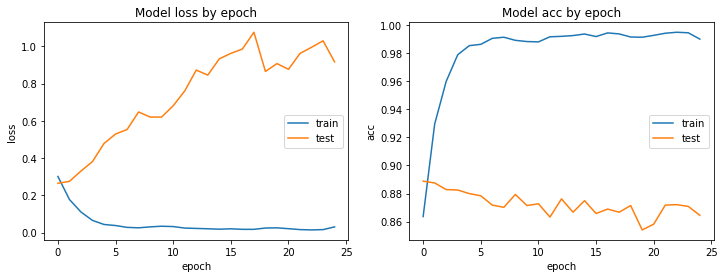

In [ ]:
plt.figure(figsize=(12,4))

plt.figure(figsize=(12,4))

plt.subplot(121)
plt.plot(cnn_history.history['loss'])
plt.plot(cnn_history.history['val_loss'])
plt.title('Model loss by epoch')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='right')

plt.subplot(122)
plt.plot(cnn_history.history['accuracy'])
plt.plot(cnn_history.history['val_accuracy'])
plt.title('Model acc by epoch')
plt.ylabel('acc')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='right')
plt.show()

In [ ]:
cnn_pred = model_cnn.predict(X_test_seq)

In [ ]:
cnn_classe = []
for i in range(len(cnn_pred)): 
 
  if cnn_pred[i,0] > 0.5: 
    cnn_classe.append(1)
  else:
    cnn_classe.append(0)

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_test, cnn_classe))